In [1]:
import requests
from bs4 import BeautifulSoup
import pandas as pd

def sector_data(sector_page_link):
    response = requests.get(sector_page_link)
    results_page = BeautifulSoup(response.content, 'lxml')
    
    sector_change = results_page.find('div', class_='tab-content-wrapper').find_all('span')[1].get_text()
    sector_market_cap = results_page.find('div', class_='tab-content-wrapper').find_all('span')[3].get_text()
    sector_market_weight = results_page.find('div', class_='tab-content-wrapper').find_all('span')[5].get_text()
    
    return sector_change, sector_market_cap, sector_market_weight

def sector_performance():
    stats_list = list()
    sector_list = list()
    measure_list = list()

    url = "https://eresearch.fidelity.com/eresearch/goto/markets_sectors/landing.jhtml"

    results_page = requests.get(url)
    soup = BeautifulSoup(results_page.content, 'lxml')
    all_performance = soup.find_all('a', class_='heading1')

    for sectors in all_performance:
        name = sectors.find('strong').get_text()
        link = "https://eresearch.fidelity.com" + sectors.get('href')
        change, mktcap, mktwgt = sector_data(link)
        stats_list.append((change, mktcap, mktwgt))
        sector_list.append(name)

    measure_list = 'Sector_Change', 'Market_Capital', 'Market_Weight'
    sector_table = pd.DataFrame(stats_list, index = sector_list, columns = measure_list)
    
    return sector_table

# Sector performance from Fidelity
sector_performance()

,Sector_Change,Market_Capital,Market_Weight
Communication Services,+0.07%,$4.46T,9.80%
Consumer Discretionary,-0.32%,$4.73T,9.73%
Consumer Staples,+0.20%,$3.41T,7.50%
Energy,+0.72%,$3.47T,5.51%
Financials,-0.72%,$7.16T,13.82%
Health Care,+0.60%,$5.66T,15.61%
Industrials,-0.03%,$3.89T,9.51%
Information Technology,-0.86%,$6.85T,19.70%
Materials,+0.58%,$1.76T,2.67%
Real Estate,+0.29%,$1.20T,2.95%


In [211]:
stock = input('Enter a stock ticker: ').upper()

Enter a stock ticker: aapl


In [212]:
def get_sector():
    import requests
    from bs4 import BeautifulSoup
    url = 'https://finance.yahoo.com/quote/' + stock + '/profile?p=' + stock

    response = requests.get(url)
    results_page = BeautifulSoup(response.content, 'lxml')
    profile = results_page.find('div', class_='asset-profile-container')
    sector = profile.find_all('strong')[0].get_text()
    industry = profile.find_all('strong')[1].get_text()

    return sector, industry
# sector and industry from Yahoo Finance
get_sector()

('Technology', 'Consumer Electronics')

### Find competitors

In [213]:
def get_competitors(stock):
    import requests
    from bs4 import BeautifulSoup
    url = 'https://www.nasdaq.com/symbol/' + stock + '/stock-comparison'

    response = requests.get(url)
    results_page = BeautifulSoup(response.content, 'lxml')
    table = results_page.find('div', class_='genTable thin')
    competitors = list()
    for i in range(4):
        competitors.append(table.find_all('input')[i].get('value'))
    
    return competitors
    
get_competitors(stock)

['IBM', 'HPQ', 'HPE', 'DVMT']

In [214]:
def get_financial_stats(ticker):
    import requests
    from bs4 import BeautifulSoup
    url = "https://finance.yahoo.com/quote/" + ticker + "/key-statistics?p=" + ticker
    
    response = requests.get(url)
    results_page = BeautifulSoup(response.content,'lxml')
    stats_lists = results_page.find_all('table')
    test_list = list()
    for i in stats_lists:
        stat_name = i.find_all('span')
        stock_stat = i.find_all('td',class_='Fz(s) Fw(500) Ta(end)')
        for j in range(len(stock_stat)):
            if not stat_name[j].get_text() == 'N/A':
                test_list.append((stat_name[j].get_text(),stock_stat[j].get_text()))
    return test_list

In [215]:
def get_row(ticker,measure_list):
    from pandas_datareader import data as web
    a = get_financial_stats(ticker)
    row = list()
    row.append(web.DataReader(ticker,"yahoo").iloc[-1,3])
    for i in measure_list:
        if not i == "Price":
            appended = 0
            for j in a:
                if j[0] == i:
                    row.append(j[1])
                    appended = 1
            if appended == 0:
                row.append('N/A')   
    return row

### Comparison Table

In [216]:
def comp_stat_table(stock):
    import pandas as pd
    measure_list = ['Price','Market Cap (intraday)','Diluted EPS','Book Value Per Share','Quarterly Revenue Growth','Quarterly Earnings Growth','Trailing Annual Dividend Yield','5 Year Average Dividend Yield','Payout Ratio','Trailing P/E','PEG Ratio (5 yr expected)','Beta (3Y Monthly)']
    r = get_competitors(stock)
    r.insert(0, stock)
    
    s_row = get_row(stock,measure_list)
    a_row = get_row(r[1],measure_list)
    b_row = get_row(r[2],measure_list)
    c_row = get_row(r[3],measure_list)
    d_row = get_row(r[4],measure_list)

    stats_list = [s_row,a_row,b_row,c_row,d_row]
    final_table = pd.DataFrame(stats_list,index = r,columns = measure_list)
    return final_table
comp_stat_table(stock)

,Price,Market Cap (intraday),Diluted EPS,Book Value Per Share,Quarterly Revenue Growth,Quarterly Earnings Growth,Trailing Annual Dividend Yield,5 Year Average Dividend Yield,Payout Ratio,Trailing P/E,PEG Ratio (5 yr expected),Beta (3Y Monthly)
AAPL,178.580002,847.43B,11.91,22.53,19.60%,31.80%,1.51%,1.73,22.84%,14.99,1.03,1.21
IBM,124.269997,112.94B,6.20,21.77,-2.10%,-1.20%,5.05%,3.25,98.08%,20.03,9.28,1.84
HPQ,23.000000,36.4B,2.74,N/A,11.70%,26.40%,2.41%,2.76,20.02%,8.39,0.90,1.90
HPE,15.000000,22.07B,2.00,15.81,3.50%,173.30%,2.17%,N/A,"Jan 2, 2019",7.50,-1.25,1.60
DVMT,105.480003,81.02B,-3.88,11.15,17.50%,N/A,N/A,2/1,N/A,N/A,0.95,N/A


In [220]:
import datetime
import dateutil.relativedelta
import numpy as np
import pandas_datareader.data as web
import matplotlib.pyplot as plt
%matplotlib inline
import statsmodels.api as sm

stocks = stock, get_competitors(stock)
three_years_ago = (datetime.date.today() - dateutil.relativedelta.relativedelta(years=3)).strftime('%Y-%m-%d')
today = datetime.date.today().strftime('%Y-%m-%d')


prices = web.DataReader(np.hstack(('SPY',)+stocks),'yahoo',three_years_ago,today)['Adj Close']
returns = prices.pct_change() # daily returns
print(returns)
print(returns.corr()['SPY']) # correlation between each stock and S&P 500

# print(plt.scatter(returns.SPY,returns.stock))

Symbols         AAPL      DVMT       HPE       HPQ       IBM       SPY
Date                                                                  
2015-12-01       NaN       NaN       NaN       NaN       NaN       NaN
2015-12-02 -0.009034       NaN -0.042281 -0.062009 -0.011183 -0.010205
2015-12-03 -0.009288       NaN -0.022073  0.016737 -0.005583 -0.014003
2015-12-04  0.033246       NaN  0.041039  0.013992  0.010869  0.019503
2015-12-07 -0.006301       NaN  0.021463 -0.003772 -0.006267 -0.006059
2015-12-08 -0.000423       NaN -0.018123  0.003292 -0.010749 -0.006719
2015-12-09 -0.022076       NaN -0.021094 -0.006562 -0.010431 -0.007780
2015-12-10  0.004757       NaN -0.008754  0.020644  0.001244  0.002581
2015-12-11 -0.025738       NaN -0.036685 -0.012136 -0.016157 -0.019381
2015-12-14 -0.006185       NaN  0.018336 -0.004095  0.010106  0.005053
2015-12-15 -0.017692       NaN  0.008310  0.004112  0.013684  0.010498
2015-12-16  0.007693       NaN  0.009616  0.004095  0.010886  0.014632
2015-1

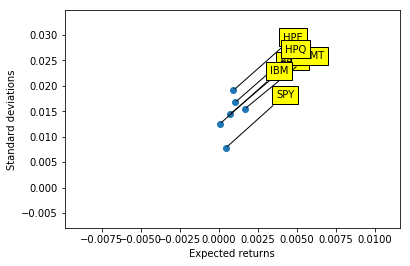

In [218]:
plt.xlabel('Expected returns')
plt.ylabel('Standard deviations')
for label,x,y in zip(returns.columns,returns.mean(),returns.std()):
    plt.annotate(
        label, 
        xy = (x,y),
        xytext = (50,50),
        textcoords = 'offset points',
        bbox = dict(fc = 'yellow'),
        arrowprops = dict(arrowstyle = '-')
    )
plt.scatter(returns.mean(), returns.std())

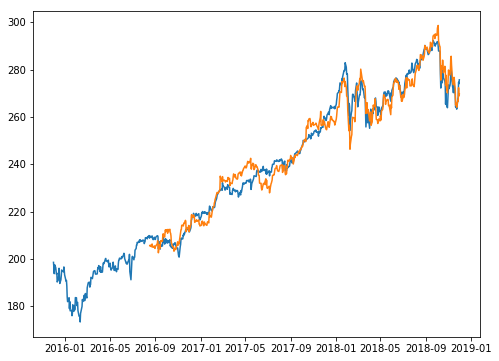

In [219]:
x = prices[np.hstack(stocks)]
x = sm.add_constant(x)
y = prices['SPY']
model = sm.OLS(y,x,missing='drop')
regression = model.fit()
# print(regression.summary())

fig,ax = plt.subplots(figsize=(8,6))
ax.plot(y) # blue
ax.plot(regression.fittedvalues) # orange